In [1]:
# encoding: utf-8

import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib
# 在 jupyter notebook 中使用 matplotlib
%matplotlib inline
# matplotlib.use('Agg')  # 服务器端使用 matplotlib
import matplotlib.pyplot as plt
import os

load_norm shape: (105192, 1)
[[-0.85610657]
 [-0.99451862]
 [-1.14643429]
 [-1.2432102 ]
 [-1.32423189]
 [-1.3366102 ]
 [-1.23308249]
 [-1.17906803]
 [-1.08454272]
 [-1.03165356]]


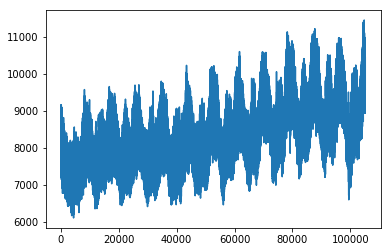

In [2]:
file1 = "./data/Hourly_load_data_(2005-2015).xlsx"
file2 = "./data/Hourly-load-data-for-2016.xlsx"

df1 = pd.read_excel(file1, sheet_name=0)
df2 = pd.read_excel(file2, sheet_name=0)

# 选出第二列
load1 = df1["Alberta Internal Load"]
load2 = df2["Alberta Internal Load"]

# 合并 05-15 年以及 16 年的数据
load = pd.concat([load1, load2], ignore_index=True)
plt.figure()
plt.plot(load)

"""
数据做标准化处理
"""
mean_val = np.mean(load)
std_val = np.std(load)
load_norm = (load - mean_val) / std_val


"""
增加数据维度
"""
load_norm = load_norm[:, np.newaxis]
print('load_norm shape: {}'.format(load_norm.shape))
print(load_norm[:10])

In [3]:
#设置常量
time_step=20      #time step
rnn_unit=64       #hidden layer units
batch_size=64     #batch size
input_size=1      #input size
output_size=1     #output size
lr=0.0001         #learning rate

train_x, train_y=[], []
for i in range(len(load_norm)- time_step - 1):
    x=load_norm[i: i + time_step]
    y=load_norm[i + 1: i + time_step + 1]
    train_x.append(x.tolist())
    train_y.append(y.tolist())

In [4]:
train_x = np.array(train_x)
train_y = np.array(train_y)
test_x = train_x[100000:]
test_y = train_y[100000:]
train_x = train_x[:100000]
train_y = train_x[:100000]
# 取100条验证集上的数据做验证
test_x = test_x[:100]
test_y = test_y[:100]

In [5]:
print('train_x shape: {}'.format(train_x.shape))
print('train_y shape: {}'.format(train_y.shape))
print('test_x shape: {}'.format(test_x.shape))
print('test_y shape: {}'.format(test_y.shape))
print(train_x[:2])

train_x shape: (100000, 20, 1)
train_y shape: (100000, 20, 1)
test_x shape: (100, 20, 1)
test_y shape: (100, 20, 1)
[[[-0.85610657]
  [-0.99451862]
  [-1.14643429]
  [-1.2432102 ]
  [-1.32423189]
  [-1.3366102 ]
  [-1.23308249]
  [-1.17906803]
  [-1.08454272]
  [-1.03165356]
  [-0.9776391 ]
  [-0.7030656 ]
  [-0.62204391]
  [-0.62992102]
  [-0.63329693]
  [-0.57365596]
  [-0.26307282]
  [ 0.09139707]
  [ 0.00699948]
  [-0.09315233]]

 [[-0.99451862]
  [-1.14643429]
  [-1.2432102 ]
  [-1.32423189]
  [-1.3366102 ]
  [-1.23308249]
  [-1.17906803]
  [-1.08454272]
  [-1.03165356]
  [-0.9776391 ]
  [-0.7030656 ]
  [-0.62204391]
  [-0.62992102]
  [-0.63329693]
  [-0.57365596]
  [-0.26307282]
  [ 0.09139707]
  [ 0.00699948]
  [-0.09315233]
  [-0.1584198 ]]]


In [6]:
# 定义 placeholder
X=tf.placeholder(tf.float32, [None,time_step,input_size])
Y=tf.placeholder(tf.float32, [None,time_step,output_size])

# 输入层、输出层权重、偏置
weights = {
    'in': tf.Variable(tf.random_normal([input_size, rnn_unit])),
    'out': tf.Variable(tf.random_normal([rnn_unit, input_size]))
}
biases = {
    'in': tf.Variable(tf.constant(0.1, shape=[rnn_unit,])),
    'out': tf.Variable(tf.constant(0.1, shape=[output_size,]))
}

In [7]:
def lstm(batch):  #参数：输入网络批次数目
    w_in = weights['in']
    b_in = biases['in']
    # 以下三行代码的运算过程如下：
    #首先将tensor X转成2维进行计算
    #[64, 20, 1] => [64 * 20, 1]
    # [64*20, 1] * [1, 64] => [64*20, 64]
    # [64*20, 64] => [64, 20, 64]
    # 整体是计算了输入
    input=tf.reshape(X,[-1, input_size])
    input_rnn=tf.matmul(input,w_in)+b_in
    input_rnn=tf.reshape(input_rnn,[-1,time_step,rnn_unit])  #将tensor转成3维，作为lstm cell的输入
    cell=tf.nn.rnn_cell.BasicLSTMCell(rnn_unit)
    init_state=cell.zero_state(batch,dtype=tf.float32)
    #output_rnn是记录lstm每个输出节点的结果，final_states是最后一个cell的结果
    output_rnn,final_states=tf.nn.dynamic_rnn(cell, input_rnn,initial_state=init_state, dtype=tf.float32)
    #[64, 20, 64] => [64 * 20, 64]
    #[64 * 20, 64] * [64, 1] => [64*20, 1]
    # [64*20, 1] + bias => [64 * 20 ,1]
    output=tf.reshape(output_rnn,[-1,rnn_unit]) #作为输出层的输入
    w_out=weights['out']
    b_out=biases['out']
    pred=tf.matmul(output,w_out)+b_out
    return pred,final_states

In [8]:
def prediction():
    y_predict = []
    y_true = []
    pred,_=lstm(1)    #预测时只输入[1,time_step,input_size]的测试数据
    saver=tf.train.Saver(tf.global_variables())
    with tf.Session() as sess:
        new_saver = tf.train.import_meta_graph('./model/best_validation.meta')
        new_saver.restore(sess, './model/best_validation')
        start = 0
        end = start + 1
        while end < len(test_x):
            pred_ = sess.run([pred], feed_dict={X:test_x[start:end]})
            y_predict.append(pred_[0][-1][0] * std_val + mean_val)
            y_true.append(test_y[start][-1][0] * std_val + mean_val)
            start += 1
            end = start + 1
    plt.figure()
    plt.plot(list(range(len(y_predict))), y_predict, color='b')
    plt.plot(list(range(len(y_predict))), y_true, color='r')


INFO:tensorflow:Restoring parameters from ./model/best_validation


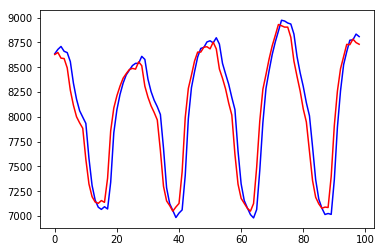

In [9]:
prediction()